In [2]:
%load_ext autoreload
%autoreload 2
from utils import *
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import pickle

In [3]:
twitter_db = connect_to_db()

In [4]:
N = 10000
cursor = twitter_db.cursor()

query = ("SELECT t1.user_id, t1.in_reply_to_user_id, t1.quoted_user_id, t1.retweeted_user_id \
        FROM tweets t1\
        WHERE lang='fr' AND \
        ((NOT (t1.text LIKE '%RT @%')) OR \
        (t1.text LIKE '%RT @%' AND \
            EXISTS \
                (SELECT * \
                FROM tweets t2 \
                WHERE t2.user_id = t1.user_id AND NOT (t2.text LIKE '%RT @%')\
                )\
        )\
        )\
        LIMIT " + str(N))

cursor.execute(query)

In [5]:
G_dict = dict()

for (user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id) in cursor:
    #print(user_id, in_reply_to_user_id, quoted_user_id, retweeted_user_id)
    if user_id not in G_dict:
        G_dict[user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        
    if not(in_reply_to_user_id is None):
        if in_reply_to_user_id not in G_dict:
            G_dict[in_reply_to_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if in_reply_to_user_id not in G_dict[user_id]['replied_to']:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] = 1
        else:
            G_dict[user_id]['replied_to'][in_reply_to_user_id] += 1
            
    if not(quoted_user_id is None):
        if quoted_user_id not in G_dict:
            G_dict[quoted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if quoted_user_id not in G_dict[user_id]['quoted']:
            G_dict[user_id]['quoted'][quoted_user_id] = 1
        else:
            G_dict[user_id]['quoted'][quoted_user_id] += 1
    
    if not(retweeted_user_id is None):
        if retweeted_user_id not in G_dict:
            G_dict[retweeted_user_id] = {'replied_to': {}, 'quoted': {}, 'retweeted': {}}
        if retweeted_user_id not in G_dict[user_id]['retweeted']:
            G_dict[user_id]['retweeted'][retweeted_user_id] = 1
        else:
            G_dict[user_id]['retweeted'][retweeted_user_id] += 1
    
cursor.close()    

True

In [6]:
G = nx.DiGraph()
G.add_nodes_from(G_dict.keys())

for (u1,v) in G_dict.items():
    for (u2, count) in v['quoted'].items():
        #print("quoted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='quoted',weight=count)
    for (u2, count) in v['replied_to'].items():
        #print("replied to : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='replied_to',weight=count)
    for (u2, count) in v['retweeted'].items():
        #print("retweeted : {}--({})-->{}".format(u1, count, u2))
        G.add_edge(u1,u2,label='retweeted',weight=count)

In [45]:
f = open("communities/graph_10000", "wb")
pickle.dump(G,f)
f.close()

In [7]:
G_undirected = nx.Graph(G)

In [8]:
partition = community_louvain.best_partition(G_undirected)

In [9]:
pos = community_layout(G_undirected, partition)

In [11]:
f = open("communities/nb_tweets_per_user", "rb")
nb_tweets_per_user = pickle.load(f)
f.close()

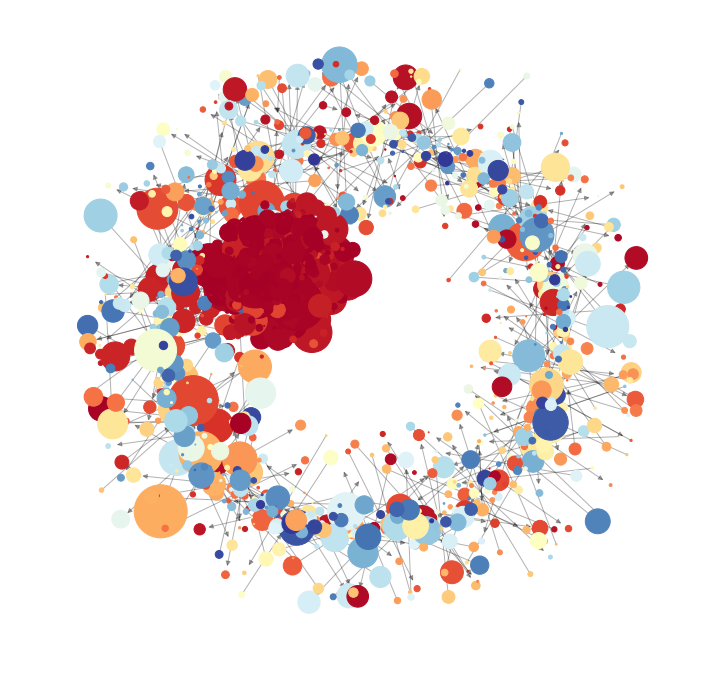

In [13]:
plt.figure(figsize=(12, 12))
nx.draw_networkx_nodes(G, pos, node_size=list(nb_tweets_per_user.values()),\
                       cmap=plt.cm.RdYlBu, node_color=[partition.get(node) for node in G.nodes()])
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.axis('off')
plt.show(G_undirected)

In [51]:
f = open("communities/partition", "wb")
pickle.dump(partition,f)
f.close()

In [52]:
f = open("communities/nb_tweets_per_user", "rb")
nb_tweets_per_user = pickle.load(f)
f.close()

In [53]:
values = list(partition.values())

In [54]:
nb_partitions = len(np.unique(values))
nb_partitions

705

In [55]:
c = Counter(values)
groups_sorted = sorted(np.unique(values), key=c.get, reverse=True)

In [56]:
groups_counts = []
for group_id in groups_sorted:
    groups_counts.append((group_id, c[group_id]))
groups_counts = np.array(groups_counts)

In [57]:
groups_filtered = groups_counts[np.where(groups_counts[:,1] >= 100)]

In [58]:
partition_filtered = dict()
G_filtered = G.copy()
nb_tweets_per_user_filtered = dict()
for user_id, group in partition.items():
    if group in groups_filtered[:,0]:
        partition_filtered[user_id] = group
        nb_tweets_per_user_filtered[user_id] = nb_tweets_per_user[user_id]
    else:
        G_filtered.remove_node(user_id)

In [59]:
pos = community_layout(G_filtered, partition_filtered)

In [60]:
len(np.unique(list(partition_filtered.values())))

12

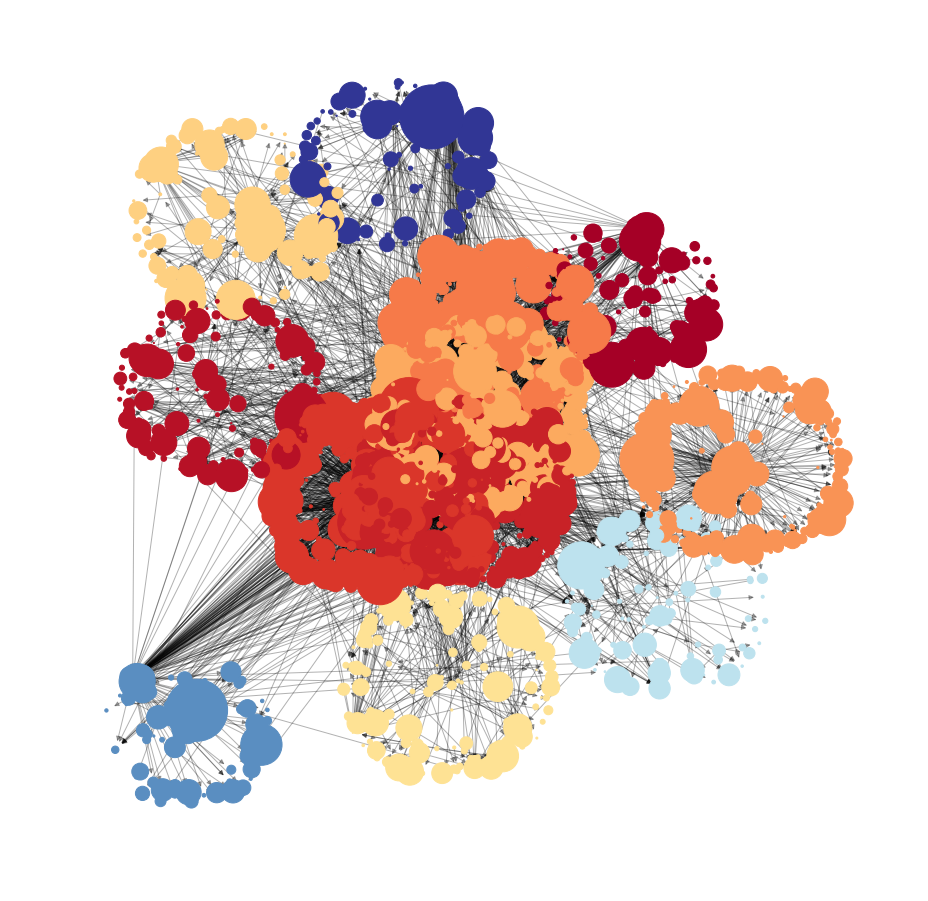

In [61]:
plt.figure(figsize=(16, 16))
nx.draw_networkx_nodes(G_filtered, pos, node_size=list(nb_tweets_per_user_filtered.values()),\
                       cmap=plt.cm.RdYlBu, node_color=[partition_filtered.get(node) for node in G_filtered.nodes()])
nx.draw_networkx_edges(G_filtered, pos, alpha=0.3)
plt.axis('off')
plt.show(G_filtered)